# **Questt ML Intern Assignment**
---
Implementation of a machine learning model that predicts the rating of Indian movies based on various features. 

## Step 1 : Dataset Creation
Importing required libraries and loading dataset with read_csv() method


In [ ]:
!pip install pandas numpy matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

df = pd.read_csv('moviedata.csv', encoding='ISO-8859-1')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The datafile contains movie entries with name, year, duration, rating, votes, director, and 3 actors.

In the datafile there are missing entries for ratings, votes and duration for some entries. For the empty duration entries we can fill them with the mean of the duration column. For ratings and votes we can fill them with the median as it is a skewed distribution. For the empty director, genre and actor entries we leave with empty strings. We can drop entries with emply name values.

## Step 2 : Data pre-processing

We can clean the dataset by filling empty cells with appropriate values.

In [ ]:
df = df.dropna(subset=['Name']) # Drop empty name value rows
df = df.dropna(subset=['Rating']) # Drop empty rating value rows seems to increace accuracy minutely

# Set null values
df['Director'].fillna('', inplace=True)
df['Actor 1'].fillna('', inplace=True)
df['Actor 2'].fillna('', inplace=True)
df['Actor 3'].fillna('', inplace=True)
df['Genre'].fillna('', inplace=True)

#Set Median Values for ratings and votes
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
df['Votes'] = df['Votes'].astype(str).replace(',', '')
df["Votes"] = df["Votes"].replace(r'[^\d.]', 0, regex=True)
df['Votes'] = df['Votes'].fillna(df['Votes'].median())
df['Votes'] = df['Votes'].astype(int)

#Set median value for empty year entries
df['Year'].fillna("-0", inplace=True)
df['Year'] = df['Year'].astype(str).str.extract('(\d+)').astype(int)
median_year = df['Year'].median()
df['Year'].replace(0, median_year, inplace=True)

# Duration is of the format 'x min'. So we split it before calculating mean
df['Duration'] = df['Duration'].fillna(0)
df['Duration'] = df['Duration'].apply(lambda x: int(x.split(' min')[0]) if isinstance(x, str) else x)
non_zero_duration = df.loc[df['Duration'] != 0, 'Duration']
median_duration = non_zero_duration.mean()
df['Duration'] = df['Duration'].replace(0,median_duration).astype(int)

### Encoding

For Genre, Director and Lead Actors we can't directly use one-hot encoding as there are approximately 25 categories, 5,939 directors and 10,289 actors.

In [ ]:
genres = []
for genres in df['Genre']:
    for genre in genres.split(', '):
        if genre not in genres:
            genres.append(genre)

actors1=np.unique(np.concatenate((df['Actor 1'].unique(),df['Actor 2'].unique(),df['Actor 3'].unique())))

print('Genres : ',len(genres))
print('Directors : ',len(df['Director'].unique()))
print('Actors : ',len(actors1))

Genres :  13
Directors :  3140
Actors :  6154


We can rather use target encoding which allows us to have an ordinal representation for Genre, Directors and Actors.

In [ ]:
# Calculate the mean target value for each category
df["Actors"] = df["Actor 1"] + ", " + df["Actor 2"] + ", " + df["Actor 3"]
mean_actors = df.groupby("Actors")["Rating"].mean()
mean_actor1 = df.groupby("Actor 1")["Rating"].mean()
mean_actor2 = df.groupby("Actor 2")["Rating"].mean()
mean_actor3 = df.groupby("Actor 3")["Rating"].mean()
mean_genre = df.groupby("Genre")["Rating"].mean()
mean_director = df.groupby("Director")["Rating"].mean()

# Create a mapping from each category to its mean target value
actors_mapping = mean_actors.to_dict()
actor1_mapping = mean_actor1.to_dict()
actor2_mapping = mean_actor2.to_dict()
actor3_mapping = mean_actor3.to_dict()
genre_mapping = mean_genre.to_dict()
director_mapping = mean_director.to_dict()

# Replace each category with its mean target value
df["Actors_encoded"] = df["Actors"].map(actors_mapping)
df["Actor1_encoded"] = df["Actor 1"].map(actor1_mapping)
df["Actor2_encoded"] = df["Actor 2"].map(actor2_mapping)
df["Actor3_encoded"] = df["Actor 3"].map(actor3_mapping)
df["Genre_encoded"] = df["Genre"].map(genre_mapping)
df["Director_encoded"] = df["Director"].map(director_mapping)

df.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Actors,Actors_encoded,Actor1_encoded,Actor2_encoded,Actor3_encoded,Genre_encoded,Director_encoded
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,"Rasika Dugal, Vivek Ghamande, Arvind Jangid",7.0,6.850000,7.000000,7.000000,6.352082,7.000000
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,"Prateik, Ishita Raj, Siddhant Kapoor",4.4,5.420000,4.400000,4.450000,5.722500,4.400000
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,"Bobby Deol, Aishwarya Rai Bachchan, Shammi Kapoor",4.7,4.788889,5.786667,5.846154,6.224490,5.358824
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,"Jimmy Sheirgill, Minissha Lamba, Yashpal Sharma",7.4,5.356000,6.050000,6.500000,6.820000,7.500000
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,"Yash Dave, Muntazir Ahmad, Kiran Bhatia",5.6,5.600000,5.883333,5.600000,5.463636,5.600000


### Data Visualisation


#### Frequency Plots

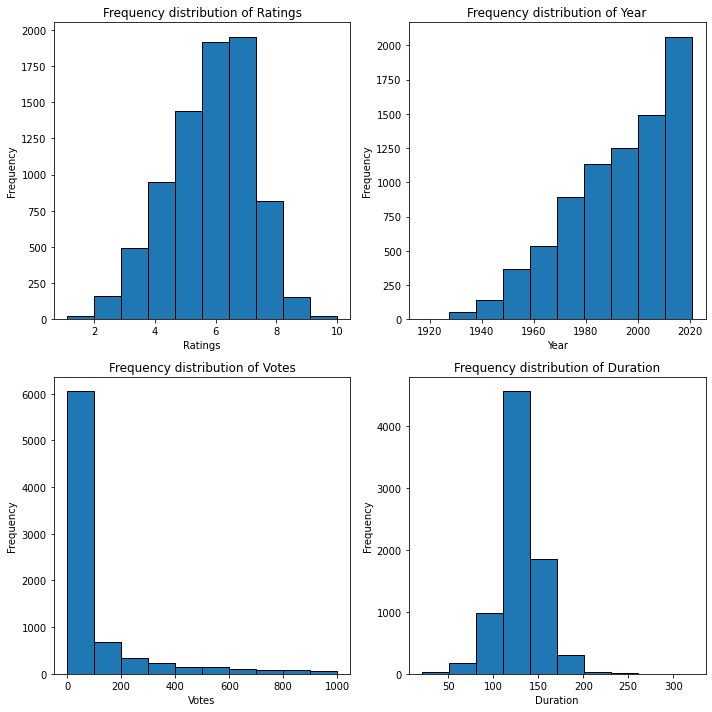

In [ ]:
# Create the histograms showing frequency distributions for Year, Duration, Rating and Votes
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(df['Rating'], bins=10, edgecolor='black')
ax[0, 1].hist(df['Year'], bins=10, edgecolor='black')
ax[1, 0].hist(df['Votes'], bins=10, edgecolor='black')
ax[1, 1].hist(df['Duration'], bins=10, edgecolor='black')

# Set the x and y labels for each subplot
ax[0, 0].set_xlabel('Ratings')
ax[0, 1].set_xlabel('Year')
ax[1, 0].set_xlabel('Votes')
ax[1, 1].set_xlabel('Duration')
ax[0, 0].set_ylabel('Frequency')
ax[0, 1].set_ylabel('Frequency')
ax[1, 0].set_ylabel('Frequency')
ax[1, 1].set_ylabel('Frequency')
ax[0, 0].set_title('Frequency distribution of Ratings')
ax[0, 1].set_title('Frequency distribution of Year')
ax[1, 0].set_title('Frequency distribution of Votes')
ax[1, 1].set_title('Frequency distribution of Duration')

# Show the plot
plt.tight_layout()
plt.show()

#### Scatter Plots

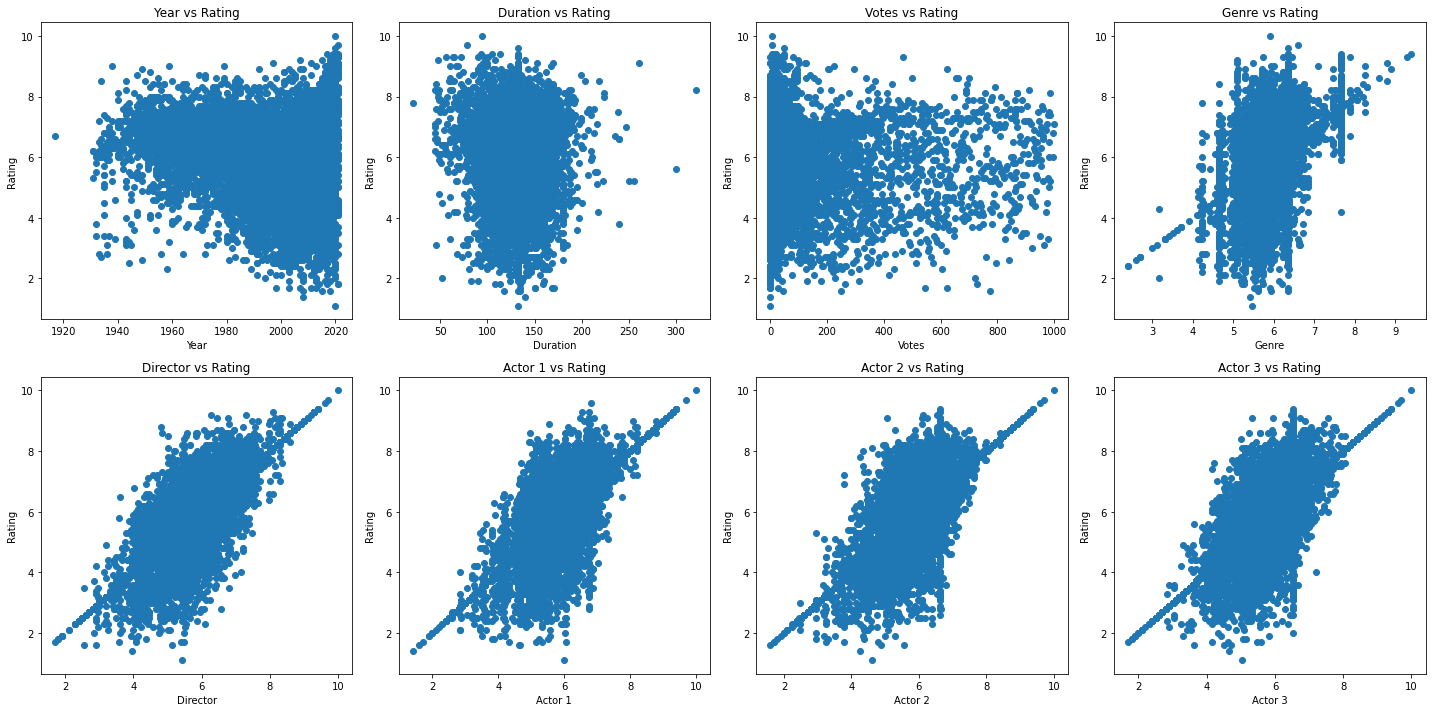

In [ ]:
# Scatter plots between different features and the target variable Rating
# Create a subplot grid with 4 rows and 2 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Scatter plot for 'Year' feature
axs[0, 0].scatter(df['Year'], df['Rating'])
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].set_title('Year vs Rating')

# Scatter plot for 'Duration' feature
axs[0, 1].scatter(df['Duration'], df['Rating'])
axs[0, 1].set_xlabel('Duration')
axs[0, 1].set_ylabel('Rating')
axs[0, 1].set_title('Duration vs Rating')

# Scatter plot for 'Votes' feature
axs[0, 2].scatter(df['Votes'], df['Rating'])
axs[0, 2].set_xlabel('Votes')
axs[0, 2].set_ylabel('Rating')
axs[0, 2].set_title('Votes vs Rating')

# Scatter plot for encoded 'Genre' feature
axs[0, 3].scatter(df['Genre_encoded'], df['Rating'])
axs[0, 3].set_xlabel('Genre')
axs[0, 3].set_ylabel('Rating')
axs[0, 3].set_title('Genre vs Rating')

# Scatter plot for encoded 'Director' feature
axs[1, 0].scatter(df['Director_encoded'], df['Rating'])
axs[1, 0].set_xlabel('Director')
axs[1, 0].set_ylabel('Rating')
axs[1, 0].set_title('Director vs Rating')

# Scatter plot for encoded 'Actor 1' feature
axs[1, 1].scatter(df['Actor1_encoded'], df['Rating'])
axs[1, 1].set_xlabel('Actor 1')
axs[1, 1].set_ylabel('Rating')
axs[1, 1].set_title('Actor 1 vs Rating')

# Scatter plot for encoded 'Actor 2' feature
axs[1, 2].scatter(df['Actor2_encoded'], df['Rating'])
axs[1, 2].set_xlabel('Actor 2')
axs[1, 2].set_ylabel('Rating')
axs[1, 2].set_title('Actor 2 vs Rating')

# Scatter plot for encoded 'Actor 3' feature
axs[1, 3].scatter(df['Actor3_encoded'], df['Rating'])
axs[1, 3].set_xlabel('Actor 3')
axs[1, 3].set_ylabel('Rating')
axs[1, 3].set_title('Actor 3 vs Rating')

# Display the plots
plt.tight_layout()
plt.show()

#### Correlation Matrix

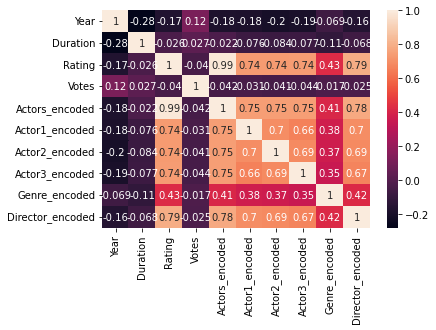

In [ ]:
import seaborn as sns

# Calculate the correlation matrix for the features
corr = df.corr()

# Plot the heatmap
sns.heatmap(corr, annot=True)

# Show the plot
plt.show()

### Scaling

We have encoded Genre, Director and Actors. Finally we scale Duration, Year, Rating and Votes using min-max scaling.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
df[['Year', 'Duration', 'Votes']] = scaler.fit_transform(df[['Year', 'Duration', 'Votes']])

## Step 3 : Splitting the data into train and test set.


As our dataset is non-uniform and quire large we can use stratified sampling to split our dataset. From the correlation heatmap, Genre_encoded, Director_encoded, Actor1_encoded, Actor2_encoded and Actor3_encoded have strong corelation, so we can use them to train our models.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Divide the ratings into 20 strata based on the frequency distribution
stratum = pd.cut(df['Rating'], bins=20, labels=False)

# Perform Stratified Sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
for train_index, test_index in sss.split(df, stratum):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]

# Create datasets
# train_columns = ['Year', 'Duration', 'Votes', 'Genre_encoded', 'Director_encoded', 'Actors_encoded']
train_columns = ['Genre_encoded', 'Director_encoded', 'Actor1_encoded', 'Actor2_encoded', 'Actor3_encoded']
y_train = X_train['Rating']
y_test = X_test['Rating']
X_train = X_train[train_columns]
X_test = X_test[train_columns]

# y = df["Rating"]
# X = df[['Year', 'Duration', 'Votes', 'Genre_encoded', 'Director_encoded', 'Actors_encoded']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Models


### Linear Regression

#### Model

In [ ]:
from sklearn.linear_model import LinearRegression

# Fit the Linear Regression Model
reg = LinearRegression().fit(X_train, y_train)

# Predict on the Test Data
y_pred_linreg = reg.predict(X_test)

#### Evaluation Metrics

Mean Squared Error: 0.4313347601364472
Mean Absolute Error: 0.49320745494718066
R2 Score: 0.7725427727824329


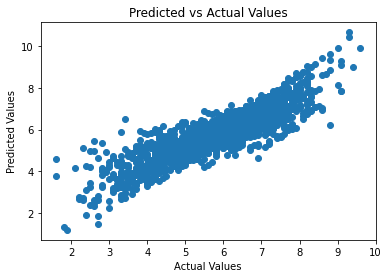

In [ ]:
# Evaluate the Model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_linreg))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_linreg))
print("R2 Score:", r2_score(y_test, y_pred_linreg))

plt.scatter(y_test, y_pred_linreg)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

#### Testing Sample Data

In [ ]:
# Custom Data
new_data_point = pd.DataFrame({'Year': [2019], 
                               'Duration': [110], 
                               'Votes': [35], 
                               'Genre': ['Comedy, Romance'], 
                               'Director': ['Ovais Khan'], 
                               'Actors': ['Prateik, Ishita Raj, Siddhant Kapoor']})


new_data_point[['Year', 'Duration', 'Votes']] = scaler.transform(new_data_point[['Year', 'Duration', 'Votes']])
new_data_point["Actors_encoded"] = new_data_point["Actors"].map(actors_mapping)
new_data_point["Genre_encoded"] = new_data_point["Genre"].map(genre_mapping)
new_data_point["Director_encoded"] = new_data_point["Director"].map(director_mapping)
new_data_point.drop(['Year', 'Duration', 'Votes', 'Genre', 'Director', 'Actors'], axis=1, inplace=True)

# Sample data
testsample=df.sample(10)
ratings = np.array(testsample["Rating"].astype(float).tolist())
testsample = testsample[train_columns]
predicted_ratings = np.round(reg.predict(testsample),2)

for i in range(len(ratings)):
    print("Rating:", ratings[i], ", Predicted:", predicted_ratings[i])

Rating: 6.8 , Predicted: 6.27
Rating: 6.8 , Predicted: 7.06
Rating: 3.5 , Predicted: 4.31
Rating: 5.4 , Predicted: 4.79
Rating: 6.4 , Predicted: 6.03
Rating: 4.9 , Predicted: 4.63
Rating: 3.2 , Predicted: 5.43
Rating: 7.2 , Predicted: 7.03
Rating: 7.1 , Predicted: 7.44
Rating: 6.8 , Predicted: 6.19


### Decision Trees

#### Model

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
y_pred_dt = dtree.predict(X_test)

#### Evaluation Metrics

Mean Squared Error: 0.8150363005050505
Mean Absolute Error: 0.609753787878788
R2 Score: 0.570204133476518


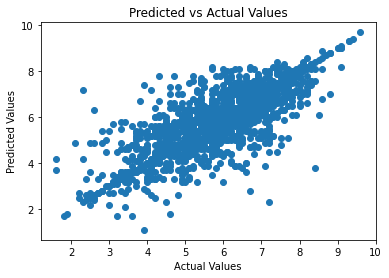

In [ ]:
# Evaluate the Model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_dt))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_dt))
print("R2 Score:", r2_score(y_test, y_pred_dt))

plt.scatter(y_test, y_pred_dt)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

#### Testing Sample Data

In [ ]:
# Sample data
# Sample data
testsample=df.sample(10)
ratings = np.array(testsample["Rating"].astype(float).tolist())
testsample = testsample[train_columns]
predicted_ratings = np.round(dtree.predict(testsample),2)

for i in range(len(ratings)):
    print("Rating:", ratings[i], ", Predicted:", predicted_ratings[i])

Rating: 6.6 , Predicted: 6.6
Rating: 4.9 , Predicted: 6.1
Rating: 4.9 , Predicted: 4.9
Rating: 5.8 , Predicted: 5.8
Rating: 4.0 , Predicted: 4.0
Rating: 3.3 , Predicted: 3.3
Rating: 5.3 , Predicted: 5.3
Rating: 8.7 , Predicted: 8.7
Rating: 8.0 , Predicted: 8.0
Rating: 7.5 , Predicted: 7.5


### Random Forests

#### Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#### Evaluation Metrics

Mean Squared Error: 0.39201164371222147
Mean Absolute Error: 0.4283643067580571
R2 Score: 0.7932791656123975


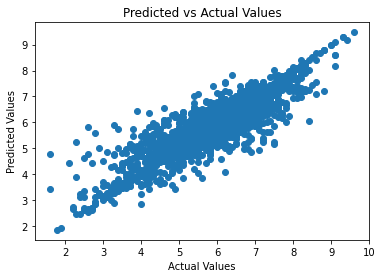

In [ ]:
# Evaluate the Model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))

plt.scatter(y_test, y_pred_rf)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

#### Testing Sample Data

In [ ]:
# Sample data
testsample=df.sample(10)
ratings = np.array(testsample["Rating"].astype(float).tolist())
testsample = testsample[train_columns]
predicted_ratings = np.round(rf.predict(testsample),2)

for i in range(len(ratings)):
    print("Rating:", ratings[i], ", Predicted:", predicted_ratings[i])

Rating: 5.0 , Predicted: 4.97
Rating: 3.8 , Predicted: 3.72
Rating: 6.2 , Predicted: 6.32
Rating: 5.4 , Predicted: 5.25
Rating: 7.7 , Predicted: 7.44
Rating: 7.3 , Predicted: 7.3
Rating: 6.5 , Predicted: 6.54
Rating: 4.6 , Predicted: 5.14
Rating: 5.0 , Predicted: 5.71
Rating: 5.5 , Predicted: 5.5


### Gradient Boosting

#### Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

#### Evaluation Metrics

Mean Squared Error: 0.38705717106104004
Mean Absolute Error: 0.45344831701204674
R2 Score: 0.7958918245393213


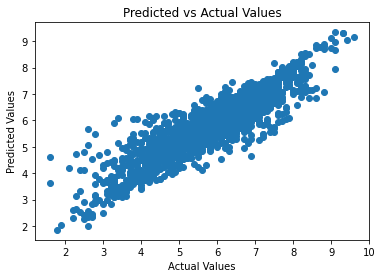

In [ ]:
# Evaluate the Model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_gb))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_gb))
print("R2 Score:", r2_score(y_test, y_pred_gb))

plt.scatter(y_test, y_pred_gb)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

#### Testing Sample Data

In [ ]:
# Sample data
testsample=df.sample(10)
ratings = np.array(testsample["Rating"].astype(float).tolist())
testsample = testsample[train_columns]
predicted_ratings = np.round(gb.predict(testsample),2)

for i in range(len(ratings)):
    print("Rating:", ratings[i], ", Predicted:", predicted_ratings[i])

Rating: 3.8 , Predicted: 4.46
Rating: 6.1 , Predicted: 6.36
Rating: 6.2 , Predicted: 6.34
Rating: 6.5 , Predicted: 6.91
Rating: 3.8 , Predicted: 4.07
Rating: 6.6 , Predicted: 5.82
Rating: 5.2 , Predicted: 6.13
Rating: 7.2 , Predicted: 6.03
Rating: 7.1 , Predicted: 6.71
Rating: 3.5 , Predicted: 5.24


## Best Model

Out of the four models Gradient Boosting was the most accurate. To perform hyperparameter tuning I chose to tweak the values of:
- n_estimators : the no. of trees
- max_depth : max depth of each decision tree
- min_samples_split : min no. of samples required to split an internal node 
- learning_rate : the step size used to update model parameters

We can use the GridSearchCV class from scikit_learn to automate the hypertuning process. It will choose the combination of hyperparameters that results in the best performance, as measured by a scoring metric we specify.

### Hyperparameter Tuning

In [ ]:
# # This tuning takes about 40 minutes to run. I have directly given the best paramsi found in the next cell
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 4, 5, 6],
#     'min_samples_split': [2, 4, 6, 8],
#     'learning_rate': [0.1, 0.05, 0.01, 0.005]
# }

# # Initialize the gradient boosting model
# gb2 = GradientBoostingRegressor()

# # Perform hyperparameter tuning using GridSearchCV
# grid_search = GridSearchCV(gb2, param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters found by GridSearchCV
# best_params = grid_search.best_params_

# # The best params we obtained was {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 300}

### Model

In [ ]:
best_params = {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 300}
print(best_params)

# Initialize the gradient boosting model with the best hyperparameters
gb2 = GradientBoostingRegressor(**best_params)
gb2.fit(X_train, y_train)

y_pred_gb2 = gb2.predict(X_test)

{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 300}


### Evaluation Metrics

Mean Squared Error: 0.37618310312374953
Mean Absolute Error: 0.43527117949233557
R2 Score: 0.8016260837972794


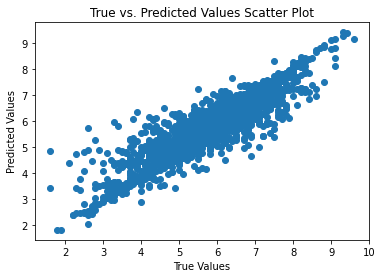

In [ ]:
# Evaluate the Model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_gb2))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_gb2))
print("R2 Score:", r2_score(y_test, y_pred_gb2))

plt.scatter(y_test, y_pred_gb2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values Scatter Plot")
plt.show()

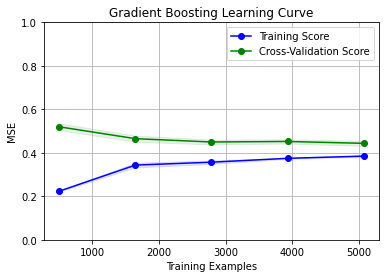

In [ ]:
from sklearn.model_selection import learning_curve

# Train the model using learning curve
train_sizes, train_scores, test_scores = learning_curve(gb, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# Calculate mean and standard deviation for the training and testing scores
train_scores_mean = -1 * np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1 * np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Gradient Boosting Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("MSE")
plt.ylim(0, 1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-Validation Score")
plt.legend(loc="best")
plt.show()

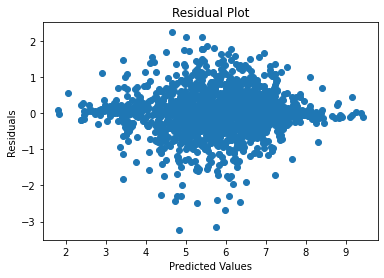

In [ ]:
# Calculate the residuals
residuals = y_test - y_pred_gb2

# Plot the residuals
plt.scatter(y_pred_gb2, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

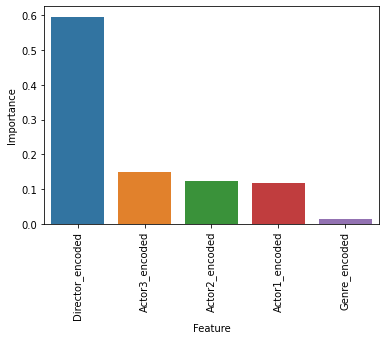

In [ ]:
# Calculate feature importance values
importance = gb2.feature_importances_

# Create a dataframe with feature names and importance values
feature_importance = pd.DataFrame({'Feature': ['Genre_encoded', 'Director_encoded', 'Actor1_encoded', 'Actor2_encoded', 'Actor3_encoded'], 'Importance': importance})
# feature_importance = pd.DataFrame({'Feature': ['Year', 'Duration', 'Votes', 'Genre_encoded', 'Director_encoded', 'Actors_encoded'], 'Importance': importance})

# Sort the dataframe by importance values
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot the feature importance using a bar plot
sns.barplot(x='Feature', y='Importance', data=feature_importance)
plt.xticks(rotation=90)
plt.show()

### Testing Sample Data

In [ ]:
# Sample data
testsample=df.sample(10)
ratings = np.array(testsample["Rating"].astype(float).tolist())
testsample = testsample[train_columns]
predicted_ratings = np.round(gb2.predict(testsample),2)

data = []
for i in range(len(ratings)):
    data.append([ratings[i], predicted_ratings[i]])

for i in range(len(data)):
    print("Rating:", data[i][0], ", Predicted:", data[i][1])


Rating: 7.6 , Predicted: 7.46
Rating: 6.4 , Predicted: 6.61
Rating: 5.8 , Predicted: 5.82
Rating: 6.9 , Predicted: 6.78
Rating: 4.1 , Predicted: 3.74
Rating: 6.1 , Predicted: 6.1
Rating: 5.3 , Predicted: 4.7
Rating: 5.1 , Predicted: 5.16
Rating: 6.5 , Predicted: 6.25
Rating: 5.3 , Predicted: 4.69
